In [1]:
from PIL import Image
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

In [2]:
IMG_DIR = Path("/workspace/data/images/image_train")

(500, 500, 3)


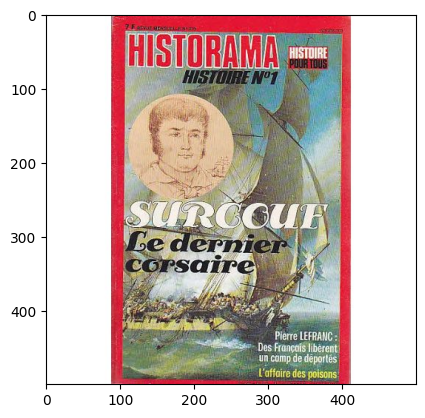

In [3]:


img = Image.open(IMG_DIR/"image_999988537_product_351615005.jpg")
arr = np.array(img)

print(arr.shape)
plt.imshow(arr)

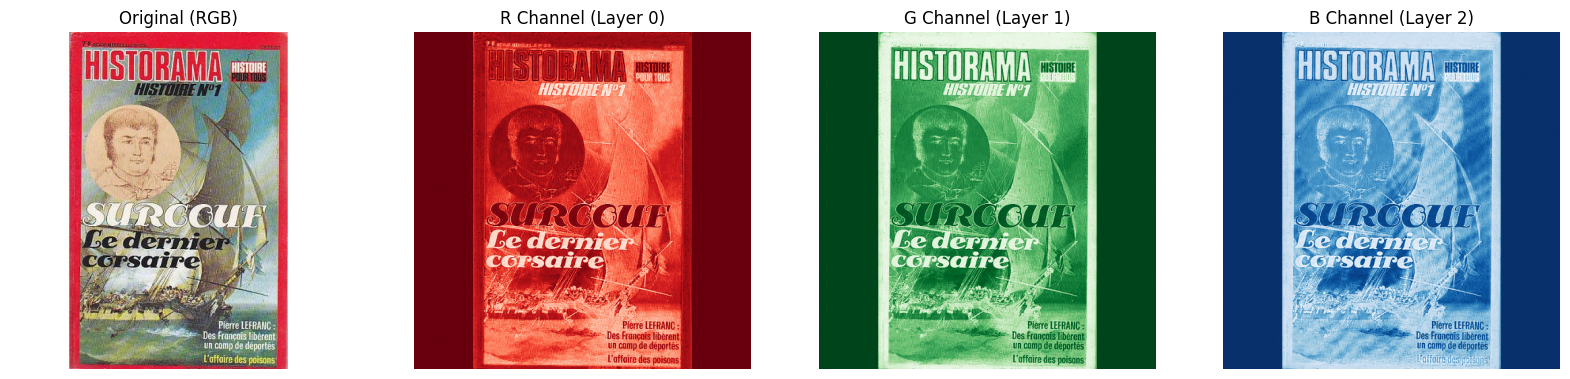

In [4]:
# separation of channels and visualization
red_channel = arr[:, :, 0]   
green_channel = arr[:, :, 1] 
blue_channel = arr[:, :, 2]  

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# show original image
axs[0].imshow(arr)
axs[0].set_title("Original (RGB)")
axs[0].axis('off')

# show red channel
axs[1].imshow(red_channel, cmap='Reds') 
axs[1].set_title("R Channel (Layer 0)")
axs[1].axis('off')

# show green channel
axs[2].imshow(green_channel, cmap='Greens')
axs[2].set_title("G Channel (Layer 1)")
axs[2].axis('off')

# show blue channel
axs[3].imshow(blue_channel, cmap='Blues')
axs[3].set_title("B Channel (Layer 2)")
axs[3].axis('off')

plt.show()

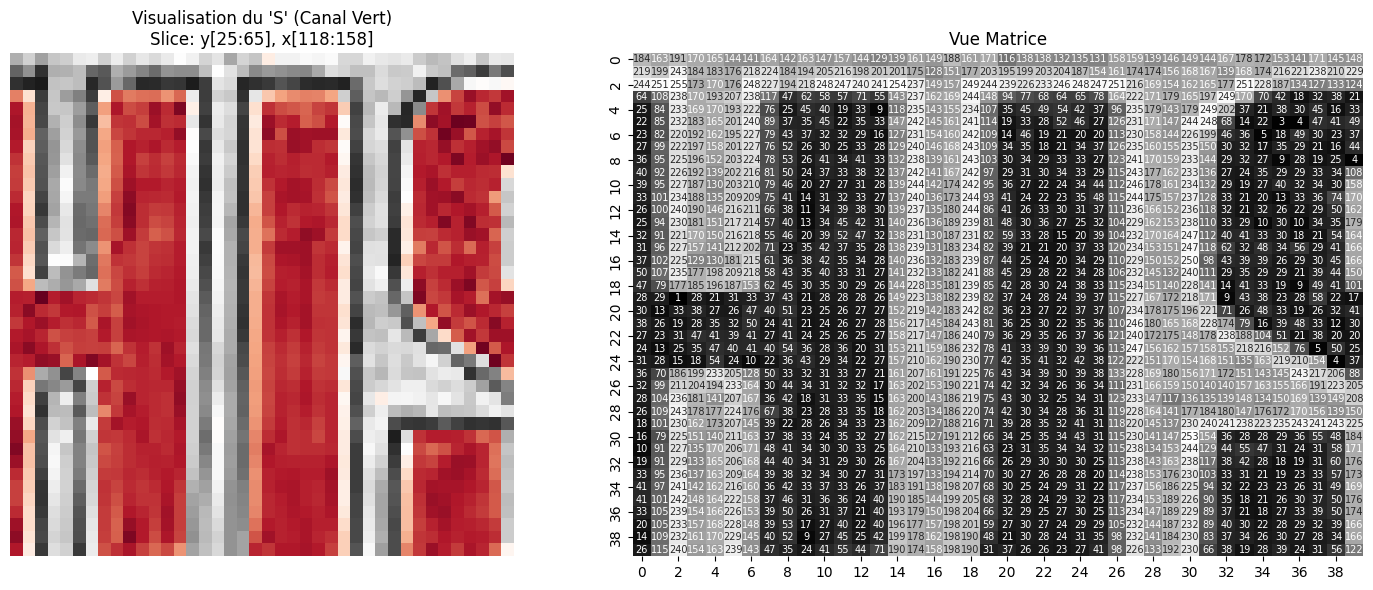

In [5]:
y_start, y_end = 25, 65    # Ancien : 35, 75 (On remonte de 10 pixels)
x_start, x_end = 118, 158  # Ancien : 105, 145 (On décale à droite de 13 pixels)

crop_region = arr[y_start:y_end, x_start:x_end, 1]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(crop_region, cmap='RdGy')
plt.title(f"Visualisation du 'S' (Canal Vert)\nSlice: y[{y_start}:{y_end}], x[{x_start}:{x_end}]")
plt.axis("off")
plt.subplot(1, 2, 2)
sns.heatmap(crop_region, annot=True, fmt="d", cmap="gray", cbar=False, annot_kws={"size": 7})
plt.title("Vue Matrice")


plt.tight_layout()
plt.show()

Extraction terminée. Taille de la matrice : (40, 40)


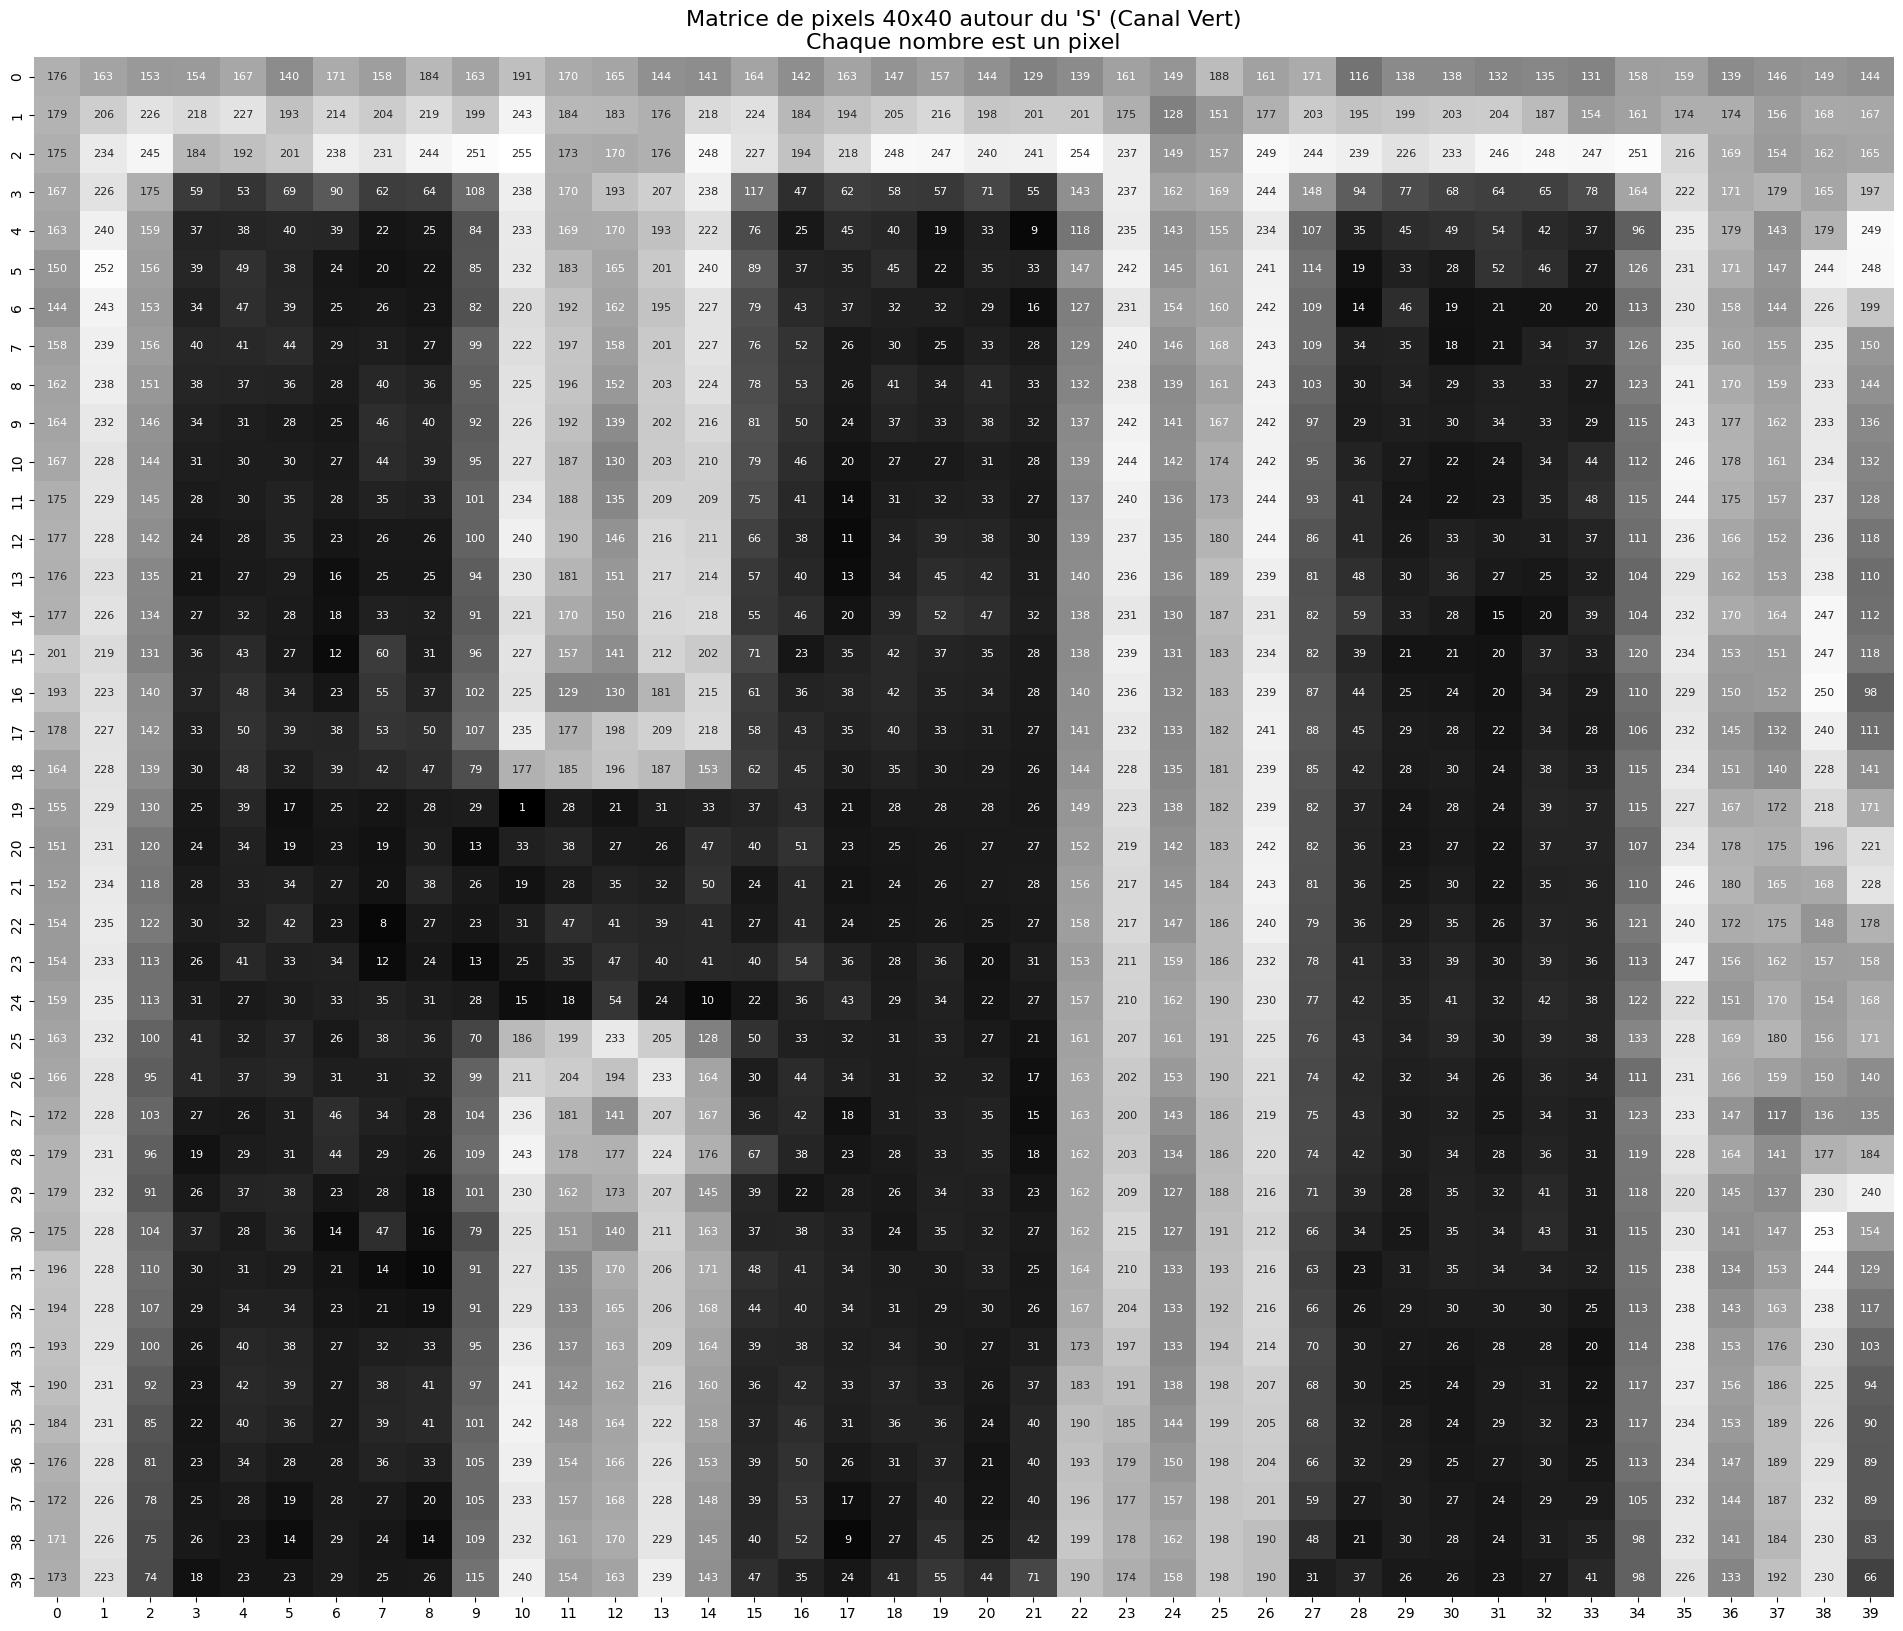

In [6]:
center_y_s = 45   # Position verticale
center_x_s = 130  # Position horizontale

offset_s = 20  # Pour obtenir une région de 40x40 pixels

# Le fond rouge aura des valeurs faibles (noir/sombre).
s_region_40x40 = arr[center_y_s - offset_s : center_y_s + offset_s,
                     center_x_s - offset_s : center_x_s + offset_s,
                     1]

print(f"Extraction terminée. Taille de la matrice : {s_region_40x40.shape}")

plt.figure(figsize=(24, 20))

sns.heatmap(s_region_40x40, 
            annot=True, 
            fmt="d", 
            cmap="gray", 
            cbar=False,
            annot_kws={"size": 8}) # Taille de police ajustée

plt.title(f"Matrice de pixels 40x40 autour du 'S' (Canal Vert)\nChaque nombre est un pixel", fontsize=16)
plt.show()

使用您截图中的真实像素值做卷积

真实像素值 (8×8):
[[176 163 153 154 167 140 171 158]
 [181 206 226 218 227 193 214 204]
 [175 234 245 184 192 201 238 231]
 [167 226 175  59  53  69  90  62]
 [163 240 159  37  38  40  39  22]
 [150 252 156  39  49  38  24  20]
 [144 243 153  34  47  39  25  26]
 [155 239 156  40  41  44  29  31]]

像素范围: 20 - 252
平均值: 132.2

Sobel 垂直核 (检测左右边缘):
[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]

Sobel 水平核 (检测上下边缘):
[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]

卷积计算

前9次计算:
位置 (0,0): 垂直=   137, 水平=   233
位置 (0,1): 垂直=   -35, 水平=   285
位置 (0,2): 垂直=   -37, 水平=   177
位置 (0,3): 垂直=   -47, 水平=   141
位置 (0,4): 垂直=    24, 水平=   214
位置 (0,5): 垂直=    70, 水平=   268
位置 (1,0): 垂直=   193, 水平=   -25
位置 (1,1): 垂直=  -255, 水平=  -241
位置 (1,2): 垂直=  -227, 水平=  -543

垂直边缘输出 (6×6):
[[ 137  -35  -37  -47   24   70]
 [ 193 -255 -227   19  116   64]
 [  82 -587 -418   40  121   -2]
 [   6 -786 -471   15   14  -61]
 [  17 -838 -441    6  -71  -67]
 [  25 -830 -434   13  -81  -57]]

水平边缘输出 (6×6):
[[ 233  285  177  141  2

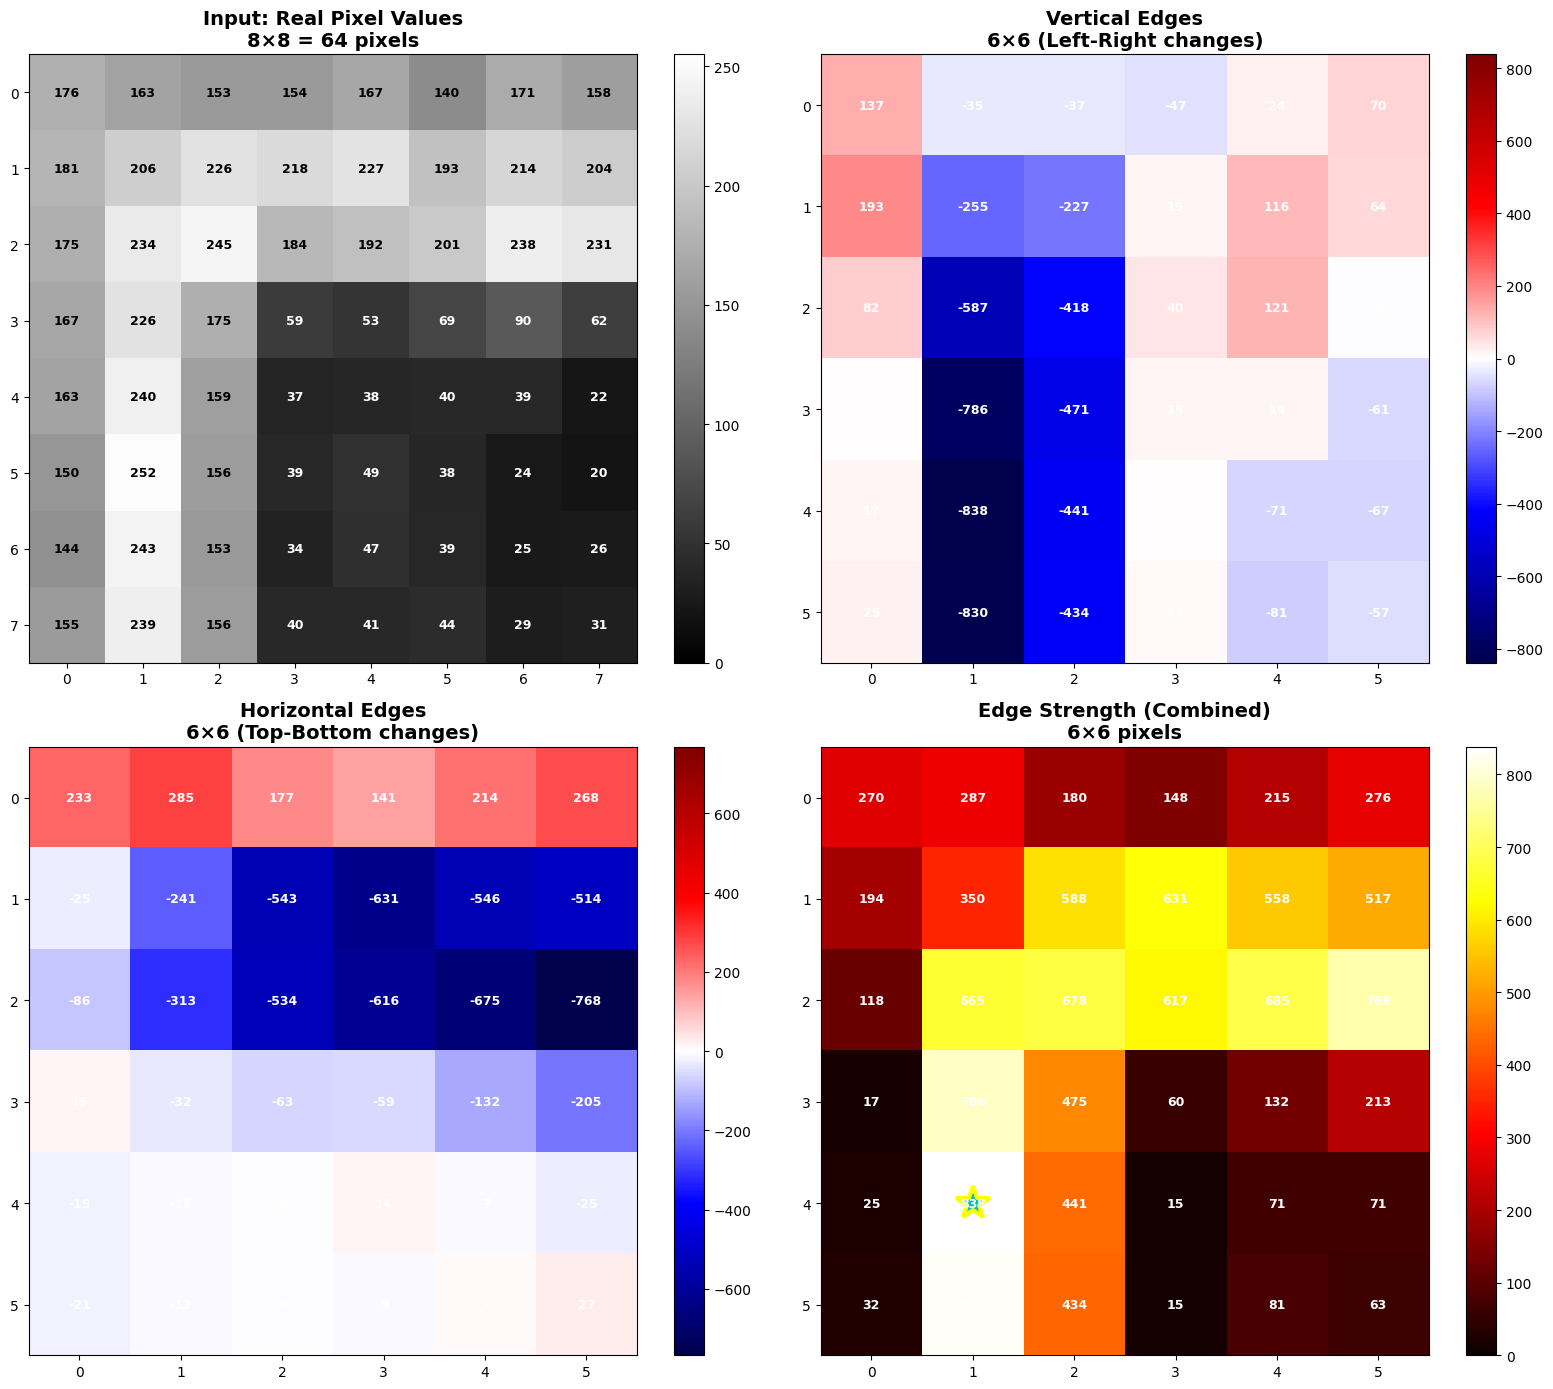

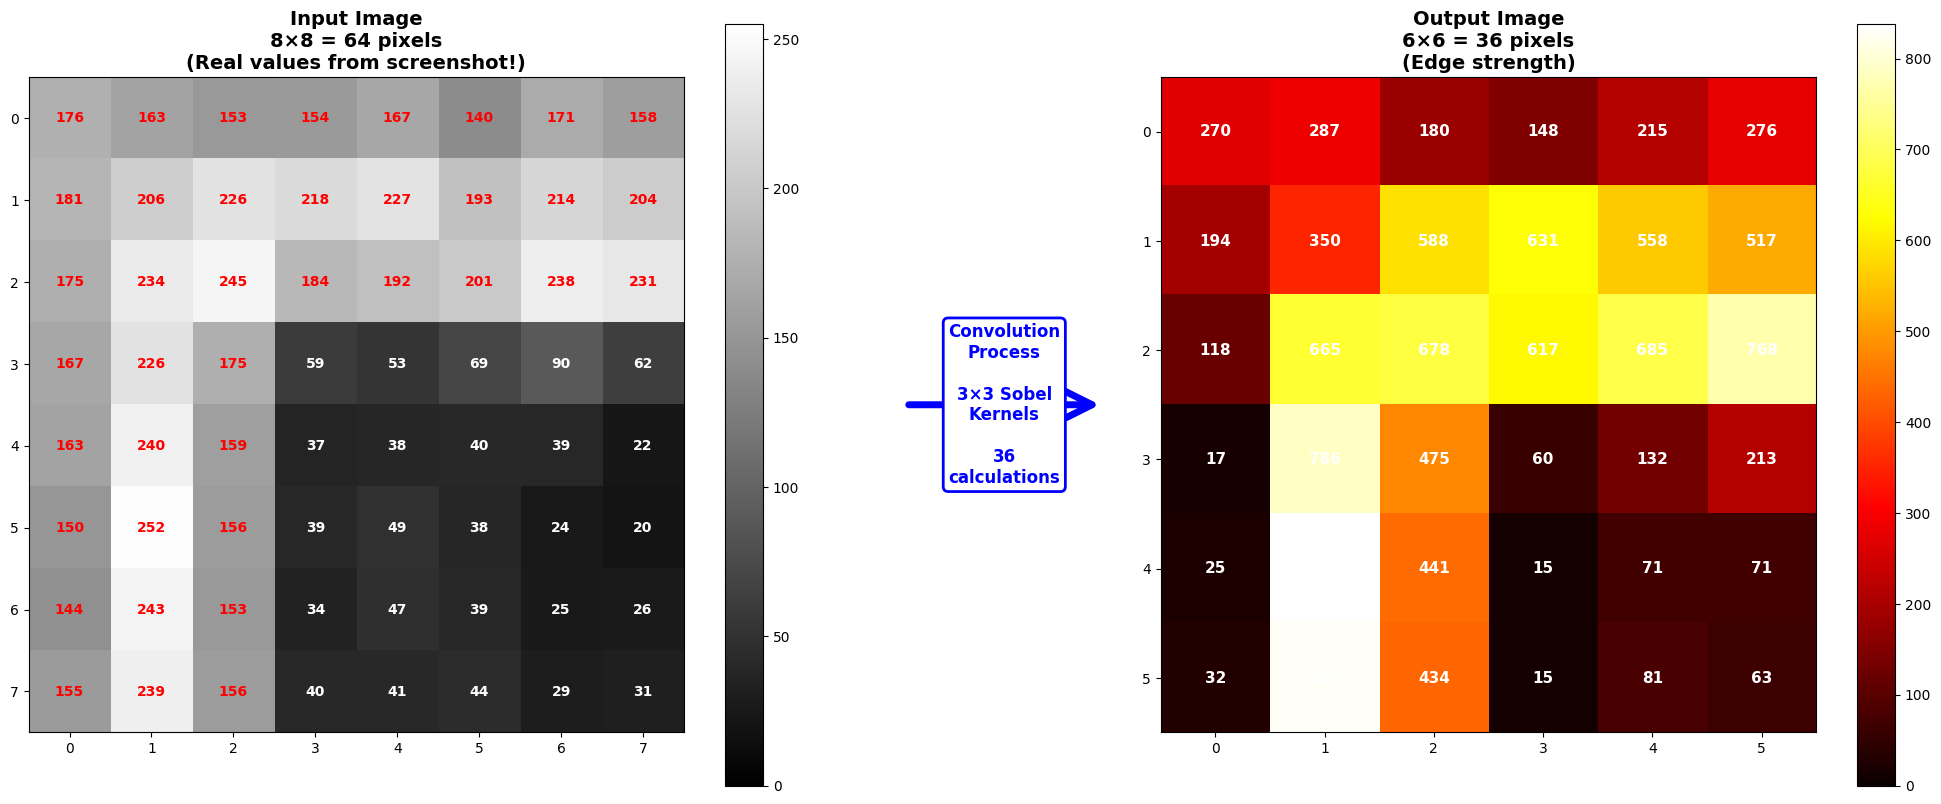


🎯 总结

成功完成！

我们做了什么：
1. 从您的截图中提取了真实像素值（8×8的数字矩阵）
2. 将这些数字作为图像数组
3. 应用 Sobel 卷积进行边缘检测
4. 生成边缘强度图（6×6）

关键发现：
• 输入: 8×8 = 64 个像素
• 输出: 6×6 = 36 个像素（缩小了2）
• 最强边缘值: 838（在位置 (np.int64(4), np.int64(1))）
• 这说明在该位置有强烈的亮度突变！

为什么有强边缘？
• 看输入数据：左上角很亮（~200），中间很暗（~40）
• 亮度突然从200跳到40 → 这是边缘！
• Sobel 成功检测到了这个突变

这就是 CNN 的基本原理：
数字 → 卷积 → 新数字 → 提取特征（如边缘）



In [8]:
# ============================================================
# 使用截图中的真实像素值做卷积演示
# 可以直接在 Jupyter Notebook 中运行
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

print("="*80)
print("使用您截图中的真实像素值做卷积")
print("="*80)

# ============================================================
# 从您的截图中提取的真实像素值！
# 这些是实际的灰度值（0-255）
# ============================================================

# 小区域演示 (8×8)
real_pixels = np.array([
    [176, 163, 153, 154, 167, 140, 171, 158],
    [181, 206, 226, 218, 227, 193, 214, 204],
    [175, 234, 245, 184, 192, 201, 238, 231],
    [167, 226, 175, 59,  53,  69,  90,  62],
    [163, 240, 159, 37,  38,  40,  39,  22],
    [150, 252, 156, 39,  49,  38,  24,  20],
    [144, 243, 153, 34,  47,  39,  25,  26],
    [155, 239, 156, 40,  41,  44,  29,  31]
])

print("\n真实像素值 (8×8):")
print(real_pixels)
print(f"\n像素范围: {real_pixels.min()} - {real_pixels.max()}")
print(f"平均值: {real_pixels.mean():.1f}")

# ============================================================
# Sobel 卷积核
# ============================================================

sobel_vertical = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])

sobel_horizontal = np.array([[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]])

print("\nSobel 垂直核 (检测左右边缘):")
print(sobel_vertical)

print("\nSobel 水平核 (检测上下边缘):")
print(sobel_horizontal)

# ============================================================
# 手动卷积计算
# ============================================================

print("\n" + "="*80)
print("卷积计算")
print("="*80)

# 输出尺寸: 8-3+1 = 6
output_v = np.zeros((6, 6))
output_h = np.zeros((6, 6))

print("\n前9次计算:")
count = 0
for i in range(6):
    for j in range(6):
        # 提取3×3区域
        region = real_pixels[i:i+3, j:j+3]
        
        # 计算卷积
        conv_v = np.sum(region * sobel_vertical)
        conv_h = np.sum(region * sobel_horizontal)
        
        output_v[i, j] = conv_v
        output_h[i, j] = conv_h
        
        count += 1
        if count <= 9:
            print(f"位置 ({i},{j}): 垂直={conv_v:6.0f}, 水平={conv_h:6.0f}")

# 计算边缘强度（组合垂直和水平）
edge_strength = np.sqrt(output_v**2 + output_h**2)

print(f"\n垂直边缘输出 (6×6):")
print(output_v.astype(int))

print(f"\n水平边缘输出 (6×6):")
print(output_h.astype(int))

print(f"\n边缘强度 (6×6):")
print(edge_strength.astype(int))

# ============================================================
# 分析结果
# ============================================================

print("\n" + "="*80)
print("结果分析")
print("="*80)

max_pos = np.unravel_index(edge_strength.argmax(), edge_strength.shape)
max_val = edge_strength[max_pos]

print(f"\n最强边缘位置: {max_pos}")
print(f"最强边缘值: {max_val:.0f}")
print(f"平均边缘强度: {edge_strength.mean():.0f}")
print(f"强边缘数量（>200）: {(edge_strength > 200).sum()} 个")

# 检查原始数据的特点
print(f"\n原始数据分析:")
print(f"  亮区域（左上）平均: {real_pixels[:3, :3].mean():.0f}")
print(f"  暗区域（中右）平均: {real_pixels[3:6, 3:6].mean():.0f}")
print(f"  对比度: {real_pixels[:3, :3].mean() - real_pixels[3:6, 3:6].mean():.0f}")

# ============================================================
# 可视化
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. 输入图像
ax = axes[0, 0]
im = ax.imshow(real_pixels, cmap='gray', vmin=0, vmax=255)
ax.set_title('Input: Real Pixel Values\n8×8 = 64 pixels', 
            fontsize=14, weight='bold')

for i in range(8):
    for j in range(8):
        val = real_pixels[i, j]
        color = 'white' if val < 128 else 'black'
        ax.text(j, i, str(int(val)), 
               ha='center', va='center', fontsize=9, color=color, weight='bold')

plt.colorbar(im, ax=ax, fraction=0.046)

# 2. 垂直边缘
ax = axes[0, 1]
im = ax.imshow(output_v, cmap='seismic', 
              vmin=-abs(output_v).max(), vmax=abs(output_v).max())
ax.set_title('Vertical Edges\n6×6 (Left-Right changes)', 
            fontsize=14, weight='bold')

for i in range(6):
    for j in range(6):
        ax.text(j, i, str(int(output_v[i, j])), 
               ha='center', va='center', fontsize=9, 
               color='white', weight='bold')

plt.colorbar(im, ax=ax, fraction=0.046)

# 3. 水平边缘
ax = axes[1, 0]
im = ax.imshow(output_h, cmap='seismic', 
              vmin=-abs(output_h).max(), vmax=abs(output_h).max())
ax.set_title('Horizontal Edges\n6×6 (Top-Bottom changes)', 
            fontsize=14, weight='bold')

for i in range(6):
    for j in range(6):
        ax.text(j, i, str(int(output_h[i, j])), 
               ha='center', va='center', fontsize=9, 
               color='white', weight='bold')

plt.colorbar(im, ax=ax, fraction=0.046)

# 4. 边缘强度
ax = axes[1, 1]
im = ax.imshow(edge_strength, cmap='hot', vmin=0)
ax.set_title('Edge Strength (Combined)\n6×6 pixels', 
            fontsize=14, weight='bold')

for i in range(6):
    for j in range(6):
        ax.text(j, i, str(int(edge_strength[i, j])), 
               ha='center', va='center', fontsize=9, 
               color='white', weight='bold')

# 标记最强边缘
ax.plot(max_pos[1], max_pos[0], 'c*', markersize=25, 
       markeredgecolor='yellow', markeredgewidth=3)

plt.colorbar(im, ax=ax, fraction=0.046)

plt.tight_layout()
plt.show()

# ============================================================
# 完整流程图
# ============================================================

fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 0.3, 1])

# 左：输入
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(real_pixels, cmap='gray', vmin=0, vmax=255)
ax1.set_title('Input Image\n8×8 = 64 pixels\n(Real values from screenshot!)', 
             fontsize=14, weight='bold')

for i in range(8):
    for j in range(8):
        val = real_pixels[i, j]
        color = 'white' if val < 128 else 'red'
        ax1.text(j, i, str(int(val)), 
                ha='center', va='center', fontsize=10, color=color, weight='bold')

plt.colorbar(im1, ax=ax1)

# 中：处理
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.axis('off')

arrow = FancyArrowPatch((1, 5), (9, 5),
                       arrowstyle='->', mutation_scale=50,
                       linewidth=5, color='blue')
ax2.add_patch(arrow)

ax2.text(5, 5, """Convolution
Process

3×3 Sobel
Kernels

36
calculations""", 
        ha='center', va='center', fontsize=12,
        weight='bold', color='blue',
        bbox=dict(boxstyle='round', facecolor='white', 
                 edgecolor='blue', linewidth=2))

# 右：输出
ax3 = fig.add_subplot(gs[0, 2])
im2 = ax3.imshow(edge_strength, cmap='hot', vmin=0)
ax3.set_title('Output Image\n6×6 = 36 pixels\n(Edge strength)', 
             fontsize=14, weight='bold')

for i in range(6):
    for j in range(6):
        ax3.text(j, i, str(int(edge_strength[i, j])), 
                ha='center', va='center', fontsize=11, 
                color='white', weight='bold')

plt.colorbar(im2, ax=ax3)

plt.tight_layout()
plt.show()

# ============================================================
# 总结
# ============================================================

print("\n" + "="*80)
print("🎯 总结")
print("="*80)
print(f"""
成功完成！

我们做了什么：
1. 从您的截图中提取了真实像素值（8×8的数字矩阵）
2. 将这些数字作为图像数组
3. 应用 Sobel 卷积进行边缘检测
4. 生成边缘强度图（6×6）

关键发现：
• 输入: 8×8 = 64 个像素
• 输出: 6×6 = 36 个像素（缩小了2）
• 最强边缘值: {max_val:.0f}（在位置 {max_pos}）
• 这说明在该位置有强烈的亮度突变！

为什么有强边缘？
• 看输入数据：左上角很亮（~200），中间很暗（~40）
• 亮度突然从200跳到40 → 这是边缘！
• Sobel 成功检测到了这个突变

这就是 CNN 的基本原理：
数字 → 卷积 → 新数字 → 提取特征（如边缘）
""")